In [1]:
# pip install qiskit[nature] -U

# Calcul de l'état fondamental et du premier niveau excité de la molécule de H2

Nous allons, pour le calcul de l'état fondamental et de l'état excité, utiliser tout d'abord la diagonalisation exacte. Par la suite, nous utiliserons la méthode Variationnelle pour le même calcul en Utilisant deux ansatze (HEA et UCCSD ansatz) ou fonctions d'éssai.

In [2]:
from qiskit_nature.units import DistanceUnit # importation du package qui donne de la distance interatomique
from qiskit_nature.second_q.drivers import PySCFDriver #importation du driver PYSCF

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

es_problem = driver.run() # définir le problème électronique

/home/taamangtchu/mambaforge/envs/qiskit-env/lib/python3.10/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [3]:
fermOp = es_problem.hamiltonian.second_q_op() # définissions du Hamiltonien fermionique en
# second quantification

Convertir les opérateurs fermioniques en opérateurs qubits. A ce stade, nous choisissons JordanWignerMapper le mapper qui sera utilisé dans l'algorithme.

In [4]:
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.operators import FermionicOp

mapper = JordanWignerMapper()

In [5]:
mapper.map(fermOp) # cette opération permet
#de convertir l'Opérateur fermionique (fermOp)en Opérateur qubit.

/home/taamangtchu/mambaforge/envs/qiskit-env/lib/python3.10/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


PauliSumOp(SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'ZIIZ', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81054798+0.j,  0.17218393+0.j, -0.22575349+0.j,  0.17218393+0.j,
 -0.22575349+0.j,  0.12091263+0.j,  0.16892754+0.j,  0.0452328 +0.j,
  0.0452328 +0.j,  0.0452328 +0.j,  0.0452328 +0.j,  0.16614543+0.j,
  0.16614543+0.j,  0.17464343+0.j,  0.12091263+0.j]), coeff=1.0)

Afin de faciliter les calculs avec la diagonalisation exacte, faisons la réduction de qubits avec le module "TaperedQubitMapper"

In [6]:
from qiskit_nature.second_q.mappers import TaperedQubitMapper # permet la reduction de qubits

In [7]:
mapperz2 = es_problem.get_tapered_mapper(mapper)
H2_z2qubit = mapperz2.map(fermOp)

print(f"Number of items in the JWM Z2 Pauli list:", len(H2_z2qubit))
print(H2_z2qubit)

Number of items in the JWM Z2 Pauli list: 3
-1.041093141516624 * I
- 0.7958748496863585 * Z
+ 0.18093119978423122 * X


L' Hamiltonien réduit s'écrit :
\begin{align}
\mathtt{H} = & h_1*I + h_2*Z + h_3*X \\
h1 = &-1.041093141516625 \\
h2 = &- 0.7958748496863575 \\
h3 = &+ 0.18093119978423122
\end{align}

A partir du Hamiltonien quelconque obtenu plus haut, calculons l'énergie à partie de la fonction SparsePauliOp.

## Utilisation de la diagonalisation exacte

### Calcul de l'énergie de l'état fondamental

Dans la méthode de la diagonalisation totale exacte, l'algorithme utilisé pour le calcul de l'état fondamental est le `NumPyMinimumEigensolve``. Le "Minimum eigensolver" ne recherche que les états réalisable et renvoie un état propre qui a la plus petite valeur propre parmi les états réalisables.

In [8]:
from qiskit.quantum_info import SparsePauliOp
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver

exact_result = NumPyMinimumEigensolver().compute_minimum_eigenvalue(H2_z2qubit)
print(f'\n The exact ground state energy is: {exact_result.eigenvalue}')


 The exact ground state energy is: -1.8572750302023784


### Calcul de l'énergie des premiers états excités

Le calcul des états excités se fait à partir avec la classe ` ExcitedStatesEigensolver`.

In [9]:
from qiskit_nature.second_q.algorithms import ExcitedStatesEigensolver
from qiskit.algorithms.eigensolvers import NumPyEigensolver

numpy_solver = NumPyEigensolver(k=4, filter_criterion=es_problem.get_default_filter_criterion())

numpy_excited_states_solver = ExcitedStatesEigensolver(mapperz2, numpy_solver)
numpy_results = numpy_excited_states_solver.solve(es_problem)

print(numpy_results)


=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -0.224911252831
> Total excited state energy (Hartree): 0.495057741618
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  None]
    - computed part:      [0.0  0.0  None]
  > Dipole moment (a.u.): [0.0  0.0  None]  Total: None
                 (debye): [0.0  0.0  None]  Total: None
 
  1: 
  * Electronic dipole moment (a.u.): [0.0  0.0  None]
    - computed part:      [0.0  0.0  None]
  > Dipole moment (a.u.): [0.0  0.0  None]  Total: None
     

## Calcul quantique

 ### Calcul VQD

 Le calcul VQD dépend d'une certaine fonction coût qui s'écrit de la manière suivante :

 \begin{equation}
	L(\lambda_K) = \langle{\psi(\lambda_k)}|\hat{H}|{\psi(\lambda_k)}\rangle + \sum_{i=0}^{k=1}\beta\langle{\psi(\lambda_{k})}|{\psi(\lambda_{i})}\rangle.
	\end{equation}

Processeur quantique  se charge de:
* estimer la valeur du paramètre $\lambda_k$ qui est utilisé pour générer un circuit de préparation d'état quantique $R(\lambda_k)$
* préparer l'état d'essai (ansatz) $$|\psi(\lambda_k)\rangle$$ en appliquant un état unitaire  $R(\lambda_k)$ sur l'état de référence $|0\rangle$ :
	\begin{equation}
			|\psi(\lambda_k)\rangle = R(\lambda_k)|0\rangle
	\end{equation}
* calculer la valeur moyenne du Hamiltonien
	\begin{equation}
			E(\lambda_k) = \langle{\psi(\lambda_k)}|H|{\psi(\lambda_k)}\rangle
	\end{equation}
    

Définissons l'ansatz ou fonction d'essai permettant d'approcher la solution au problème.

Dans le cas du calcul VQD, les ansatze utilisés sont du type HEA et UCCSD.



#### Cas du HEA ansatz
L'ansatz de type HEA que nous allons utiliser ici est le "RealAmplitudes".

In [10]:
from qiskit.circuit.library import RealAmplitudes # importation de l'ansatz de type HEA

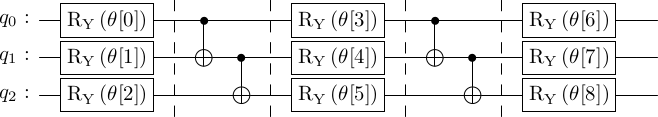

In [11]:
hea_ansatz = RealAmplitudes(3, entanglement='linear', reps=2, insert_barriers=True)
hea_ansatz.decompose().draw('latex') # decompose les couches en portes standards

#### Cas du UCCSD ansatz

In [12]:
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD # importation de
#l'ansatz et de l'état initial HartreeFock.

Définissons l'état de référence Hartree-Fock

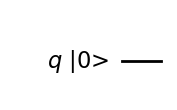

In [13]:
hf_state = HartreeFock(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapperz2)
hf_state.draw('mpl', initial_state = True)

Définissons l'ansatz UCCSD avec pour état initial l'état Hartree-Fock

In [14]:
uccsd_ansatz = UCCSD(
    es_problem.num_spatial_orbitals,
    es_problem.num_particles,
    mapperz2,
    initial_state = hf_state)

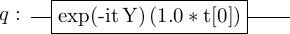

In [15]:
uccsd_ansatz.decompose().draw('latex')

Initialisons l'optimiseur, l'estimateur, l'ansatz et le solver

In [16]:
from qiskit.algorithms.optimizers import SLSQP #cet optimiseur est idéal
#pour les problèmes mathématiques pour lesquels la fonction objectif et les contraintes sont deux fois continûment différentiables
optimizer = SLSQP()

In [17]:
from qiskit.primitives import Estimator, Sampler
estimator = Estimator() # fonction permettant d'estimer une propriété inconnue d'un état quantique
# à partir d'un échantillon quantique (Sample), un processus de mesure permettant d'obtenir des
# données à partir d'un état quantique.

In [18]:
ansatz    = hea_ansatz, uccsd_ansatz

In [19]:
from qiskit.algorithms.state_fidelities import  ComputeUncompute
fidelity  = ComputeUncompute(Sampler()) # calculer la fidélité permet d'assurer l'orthogonalité des états.

Initialiser le solver VQD

In [20]:
from qiskit.algorithms.eigensolvers.vqd import VQD, VQDResult
vqd_excited_states_solver1 = VQD(estimator, fidelity, hea_ansatz, optimizer, k=2)
vqd_excited_states_solver2 = VQD(estimator, fidelity, uccsd_ansatz, optimizer, k=2)#, "sd")

In [21]:
result1 = vqd_excited_states_solver1.compute_eigenvalues(mapperz2.map(fermOp)) # affiche le
# résultat VQD lorsque le HEA ansatz est utilisé et calcule les valeurs popres

result2 = vqd_excited_states_solver2.compute_eigenvalues(mapperz2.map(fermOp)) # affiche le
# résultat VQD lorsque le UCCSD ansatz est utilisé et calcule les valeurs popres

In [22]:
eigenvalue1 = result1.eigenvalues.real # Valeurs propres pour le HEA
eigenvalue2 = result2.eigenvalues.real # Valeurs propres pour le UCCSD ansatz

In [23]:
print(eigenvalue1)
print("\n\n")
print(eigenvalue2)
# affiche les valeurs propres.

[-1.85727501 -0.22491127]



[-1.85727472 -0.22491157]


Imprimons à présent les résultats avec la diagonalisation exact, ainsi-que les résultats VQD pour le HEA et le UCCSD ansatz et faisons une petite comparaisons de ces résultats.

In [ ]:
vqd_values1 = result1.optimal_values.real
vqd_values2 = result2.optimal_values.real

print(numpy_results)
print("\n\n")
print(vqd_values1)
print("\n\n")
print(vqd_values2)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== EXCITED STATE ENERGIES ===
 
  1: 
* Electronic excited state energy (Hartree): -0.224911252831
> Total excited state energy (Hartree): 0.495057741618
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
  1:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  None]
    - computed part:      [0.0  0.0  None]
  > Dipole moment (a.u.): [0.0  0.0  None]  Total: None
                 (debye): [0.0  0.0  None]  Total: None
 
  1: 
  * Electronic dipole moment (a.u.): [0.0  0.0  None]
    - computed part:      [0.0  0.0  None]
  > Dipole moment (a.u.): [0.0  0.0  None]  Total: None
     

Nous constatons que, les états fondamentaux et excités obtenus dans le cas de la VQD pour le HEA et le UCCSD ansatz sont similaires et se raprochent de ceux obtenus dans le cas de la diagonalisation exacte. Le HEA et le UCCSD ansatz sont donc deux ansatze appropriés pour le calcul VQD.